# Rozpoznawanie gestów z akcelerometru – CNN-LSTM

In [28]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

In [29]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie treningowe: {device}')


Urządzenie treningowe: cuda


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [32]:
# 4. Parametry i lista gestów
DATA_FOLDER = '/content/data'
GESTURES = [
    "przesuniecie_w_prawo", "przesuniecie_w_lewo",
    "przesuniecie_w_gore", "przesuniecie_w_dol",
    "okrag_zgodnie_z_ruchem_wskazowek", "okrag_przeciwnie_do_ruchu_wskazowek",
    "litera_Z", "litera_V"
]
SEQUENCE_LENGTH = 60
OVERLAP_RATIO = 0.7
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50


In [33]:
# 5. Przygotowanie Dataset
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [34]:
# 6. Definicja modelu CNN-LSTM
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64, n_classes=len(GESTURES)):
        super().__init__()
        # CNN
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        self.pool  = nn.MaxPool1d(2)
        # LSTM
        self.lstm  = nn.LSTM(64, hidden_size, batch_first=True, dropout=0.2)
        # FC
        self.fc1   = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2   = nn.Linear(32, n_classes)
        self.relu  = nn.ReLU()
    def forward(self, x):
        # x: (batch, seq_len, features) -> (batch, features, seq_len)
        x = x.transpose(1,2)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # (batch, features, seq) -> (batch, seq, features)
        x = x.transpose(1,2)
        # LSTM
        out, _ = self.lstm(x)
        last = out[:,-1,:]                  # ostatni krok
        x = self.relu(self.fc1(last))
        x = self.dropout(x)
        return self.fc2(x)


In [35]:
# 7. Funkcja ładowania i tworzenia sekwencji
def load_sequences(folder):
    scaler = StandardScaler()
    seqs, labs = [], []
    for idx, label in enumerate(GESTURES):
        files = [f for f in os.listdir(folder) if f.startswith(label) and f.endswith('.csv')]
        for fn in files:
            df = pd.read_csv(os.path.join(folder, fn))
            arr = df[['acc_x','acc_y','acc_z']].values
            if len(arr) < SEQUENCE_LENGTH: continue
            arr = scaler.fit_transform(arr)
            step = int(SEQUENCE_LENGTH * (1 - OVERLAP_RATIO))
            for start in range(0, len(arr)-SEQUENCE_LENGTH+1, step):
                seqs.append(arr[start:start+SEQUENCE_LENGTH])
                labs.append(idx)
    print(f'Utworzono {len(seqs)} sekwencji, rozkład gestów: {Counter(labs)}')
    return np.array(seqs), np.array(labs)

# Załaduj dane
X, y = load_sequences(DATA_FOLDER)


Utworzono 13482 sekwencji, rozkład gestów: Counter({3: 1698, 2: 1697, 4: 1692, 6: 1690, 0: 1685, 5: 1679, 7: 1679, 1: 1662})


In [36]:
# 8. Podział na zbiory i DataLoadery
dataset = GestureDataset(X, y)
n_train = int(0.8 * len(dataset))
n_val   = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')


Train: 10785, Val: 2697


In [37]:
# 9. Inicjalizacja modelu, optymalizatora, funkcji straty
model = CNN_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [38]:
# 10. Pętla trenowania i walidacji
best_acc = 0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    # trening
    model.train()
    tloss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    # walidacja
    model.eval()
    vloss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
            _, mx = preds.max(1)
            correct += (mx==yb).sum().item()
            total   += yb.size(0)
    # wyniki
    train_loss = tloss/len(train_loader)
    val_loss   = vloss/len(val_loader)
    val_acc    = correct/total*100
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'E{epoch:02d}/{EPOCHS}  TrainLoss:{train_loss:.4f}  ValLoss:{val_loss:.4f}  ValAcc:{val_acc:.2f}%')


E01/50  TrainLoss:1.2974  ValLoss:0.7858  ValAcc:74.79%
E02/50  TrainLoss:0.8487  ValLoss:0.5663  ValAcc:81.65%
E03/50  TrainLoss:0.6888  ValLoss:0.4946  ValAcc:83.54%
E04/50  TrainLoss:0.6190  ValLoss:0.4744  ValAcc:85.09%
E05/50  TrainLoss:0.5826  ValLoss:0.4831  ValAcc:84.80%
E06/50  TrainLoss:0.5759  ValLoss:0.4388  ValAcc:84.95%
E07/50  TrainLoss:0.5495  ValLoss:0.4127  ValAcc:86.06%
E08/50  TrainLoss:0.4998  ValLoss:0.4044  ValAcc:86.39%
E09/50  TrainLoss:0.4972  ValLoss:0.4093  ValAcc:86.99%
E10/50  TrainLoss:0.4766  ValLoss:0.3932  ValAcc:86.73%
E11/50  TrainLoss:0.4797  ValLoss:0.3796  ValAcc:87.13%
E12/50  TrainLoss:0.4487  ValLoss:0.4439  ValAcc:84.54%
E13/50  TrainLoss:0.5096  ValLoss:0.3663  ValAcc:87.69%
E14/50  TrainLoss:0.4201  ValLoss:0.3512  ValAcc:88.10%
E15/50  TrainLoss:0.3976  ValLoss:0.3632  ValAcc:88.28%
E16/50  TrainLoss:0.4069  ValLoss:0.3220  ValAcc:88.95%
E17/50  TrainLoss:0.4221  ValLoss:0.3786  ValAcc:87.28%
E18/50  TrainLoss:0.4384  ValLoss:0.3430  ValAcc

In [39]:
# 11. Wczytanie najlepszego modelu i raport
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb).cpu()
        all_preds += out.argmax(1).tolist()
        all_trues += yb.tolist()
print(classification_report(all_trues, all_preds, target_names=GESTURES))


                                     precision    recall  f1-score   support

               przesuniecie_w_prawo       0.90      0.90      0.90       327
                przesuniecie_w_lewo       0.90      0.90      0.90       339
                przesuniecie_w_gore       0.94      0.99      0.97       349
                 przesuniecie_w_dol       0.96      0.94      0.95       316
   okrag_zgodnie_z_ruchem_wskazowek       0.86      0.90      0.88       355
okrag_przeciwnie_do_ruchu_wskazowek       0.89      0.86      0.88       328
                           litera_Z       0.92      0.92      0.92       350
                           litera_V       0.95      0.92      0.93       333

                           accuracy                           0.92      2697
                          macro avg       0.92      0.92      0.92      2697
                       weighted avg       0.92      0.92      0.92      2697



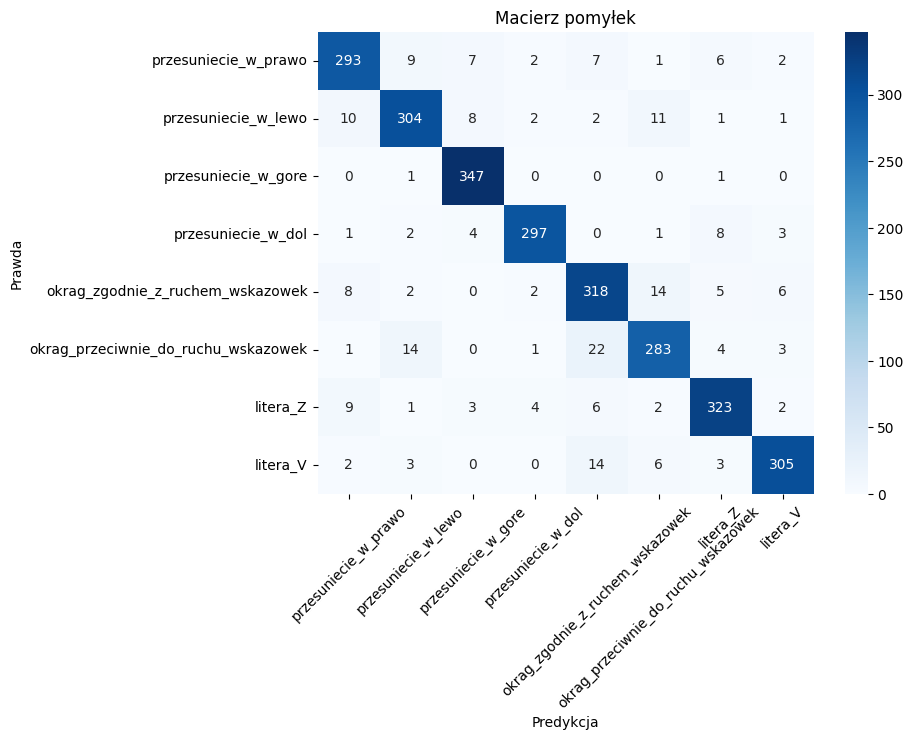

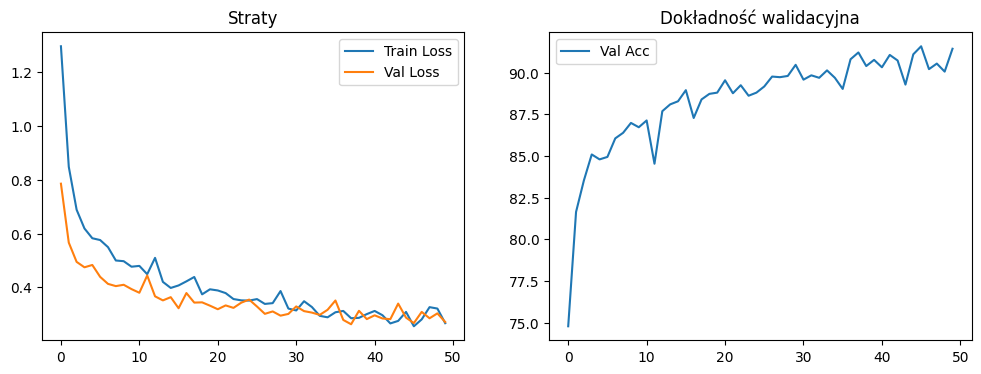

In [40]:
# 12. Wizualizacja: macierz pomyłek i historia trenowania
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES, cmap='Blues')
plt.xlabel('Predykcja'); plt.ylabel('Prawda'); plt.title('Macierz pomyłek')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title('Straty')
plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Dokładność walidacyjna')
plt.show()
